# Preprocessing

In [1]:
%load_ext autoreload

In [60]:
%autoreload 2

In [3]:
import torch

In [61]:
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel
from src.utils import *
import json

In [5]:
connection = Connection()
# Get client
client = connection.get_client()

In [6]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm',
       'well_id'],
      dtype='object')

In [7]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [8]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Preprocessing well W06 with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W08 with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W10 with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W11 with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W15 with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W18 with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mp

755

In [9]:
summarize_null(df_all_wells_preprocessed)

qo_well_test     0
qg_well_test     0
qw_well_test     0
well_code        0
dhp              0
dht              0
whp              0
wht              0
choke            0
dcp              0
qo_mpfm         30
qg_mpfm         30
qw_mpfm         30
wc_mpfm          0
well_id          0
time_idx         0
dtype: int64

In [10]:
df_train, df_val, df_test = get_random_train_test_split_per_well_with_order_preserved(df=df_all_wells_preprocessed)
len(df_train), len(df_val), len(df_test)

(530, 80, 145)

In [11]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)



In [12]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry,
)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.6394


In [13]:
model.score_physics(df_test)

{'W06': {'qo': {'r2': 0.7392123062429142,
   'mae': 11.850913993334387,
   'rmse': 16.41763167258231,
   'mape (%)': 11.589911775711737,
   'mpe (%)': 2.311027473994003},
  'qw': {'r2': -0.058460948891572384,
   'mae': 1.0305292381221978,
   'rmse': 1.1845048819211337,
   'mape (%)': 1133.9991923789207,
   'mpe (%)': 1097.2597046114804},
  'qg': {'r2': 0.5023929836650347,
   'mae': 2411.5955582149813,
   'rmse': 2892.258086762541,
   'mape (%)': 14.40817766106254,
   'mpe (%)': -9.048211850792896},
  'wgr': {'r2': -0.43380950851614,
   'mae': 7.29258296399189e-05,
   'rmse': 8.689613209561367e-05,
   'mape (%)': 1171.9617202225204,
   'mpe (%)': 1142.5241170793408},
  'gor': {'r2': -154.4676128969489,
   'mae': 16.80238765615248,
   'rmse': 21.430715722550215,
   'mape (%)': 13.540736150409863,
   'mpe (%)': -9.467479559408192}},
 'W08': {'qo': {'r2': -1.1706782301669119,
   'mae': 17.405157950074763,
   'rmse': 21.445289612407844,
   'mape (%)': 73.69088984832071,
   'mpe (%)': -44.81

In [14]:
model.score_hybrid(df_test)

{'W06': {'qo': {'r2': 0.844326191538331,
   'mae': 9.438571373018522,
   'rmse': 12.68454041052399,
   'mape (%)': 7.66391609830598,
   'mpe (%)': -3.2651377542100644},
  'qw': {'r2': -1.5030994612146418,
   'mae': 1.4115403415792767,
   'rmse': 1.8215390604058819,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.9278183514938033,
   'mae': 905.4418405228404,
   'rmse': 1101.5575578782584,
   'mape (%)': 6.49139894013943,
   'mpe (%)': -2.1877322321917028},
  'wgr': {'r2': -1.5858681155466083,
   'mae': 9.138780605345778e-05,
   'rmse': 0.00011669651946600626,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -28.4188560576946,
   'mae': 7.876235687541613,
   'rmse': 9.322440087103827,
   'mape (%)': 6.355189507142793,
   'mpe (%)': 1.5906622888633082}},
 'W08': {'qo': {'r2': 0.6471573446231785,
   'mae': 6.872116090531987,
   'rmse': 8.64618912886665,
   'mape (%)': 66.67415420289373,
   'mpe (%)': 33.149657860208706},
  'qw': {'r2': 0.1912341172293266,
   'mae

In [15]:
model.score_mpfm(df=df_test)

{'W06': {'qo': {'r2': 0.9447728957557524,
   'mae': 6.069736176229145,
   'rmse': 7.5551501058673285,
   'mape (%)': 4.457944360912968,
   'mpe (%)': 4.457944360912968},
  'qw': {'r2': -1.1941941206295716,
   'mae': 1.3290141009689507,
   'rmse': 1.7054420176747302,
   'mape (%)': 119.66562626636453,
   'mpe (%)': -56.07285090709634},
  'qg': {'r2': 0.9640994323728436,
   'mae': 547.7762513607852,
   'rmse': 776.8630293556724,
   'mape (%)': 3.8414844012442515,
   'mpe (%)': 3.8414844012442515},
  'wgr': {'r2': -1.3618749639980092,
   'mae': 8.722640234899362e-05,
   'rmse': 0.00011152780860534366,
   'mape (%)': 118.93999899490157,
   'mpe (%)': -56.98290876112348},
  'gor': {'r2': -14.05650858331636,
   'mae': 4.533592012949821,
   'rmse': 6.669278422736748,
   'mape (%)': 3.6348837869604003,
   'mpe (%)': -0.49876104686108574}},
 'W08': {'qo': {'r2': 0.777798289442154,
   'mae': 4.166492183576578,
   'rmse': 6.861323391979189,
   'mape (%)': 69.7709929100796,
   'mpe (%)': 51.512882

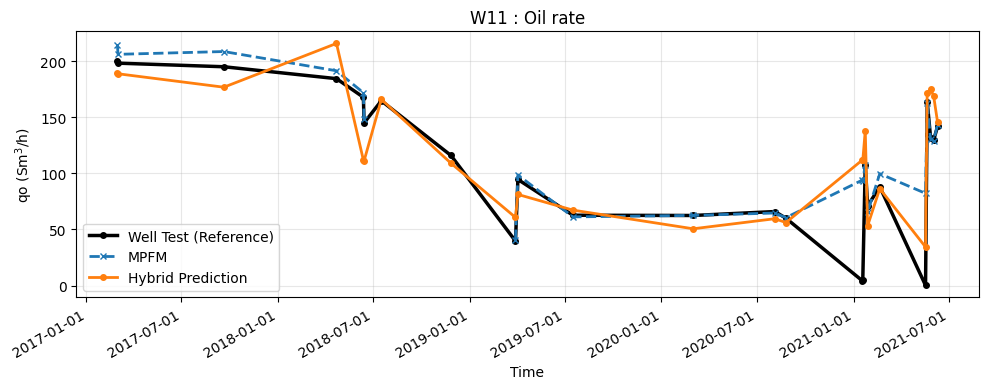

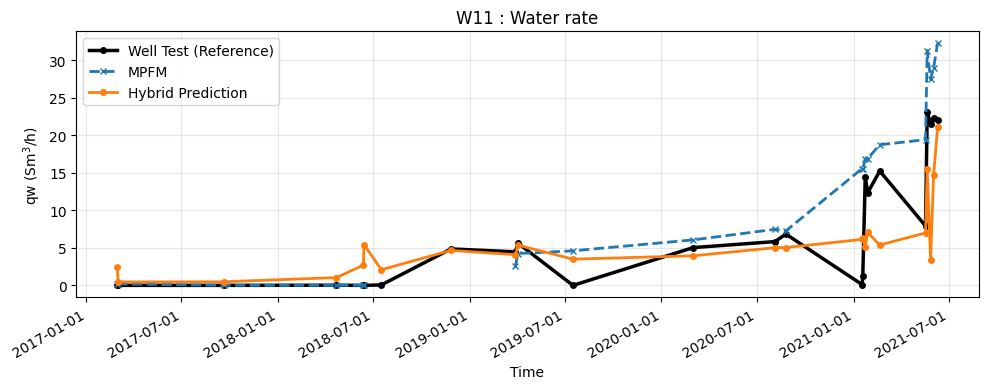

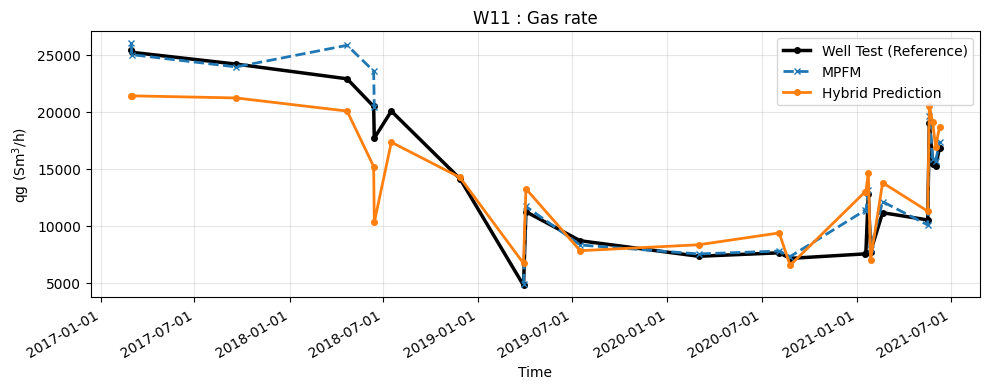

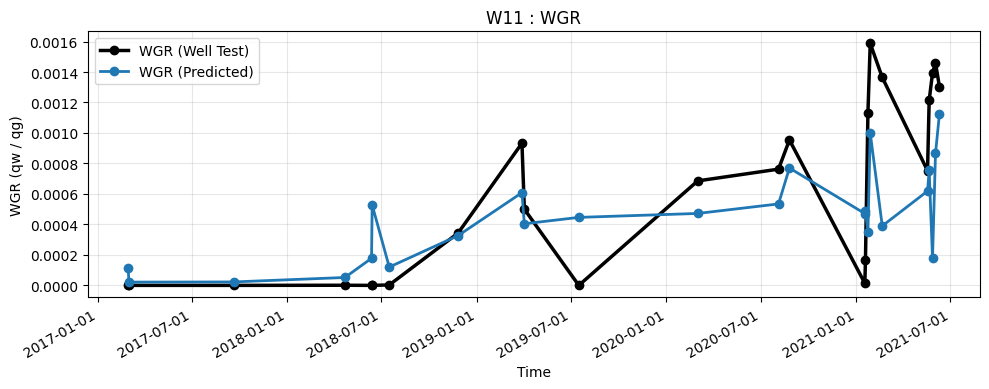

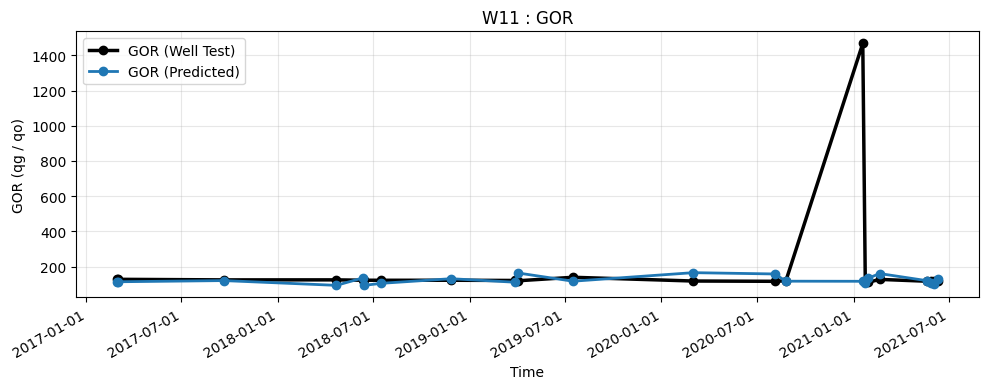

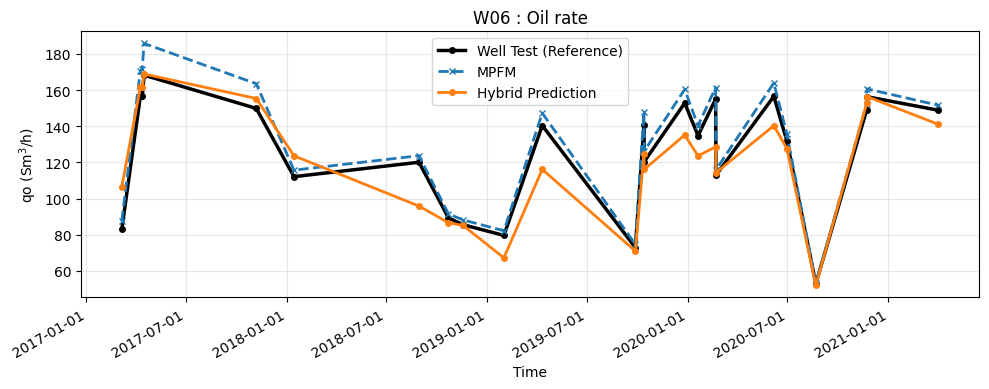

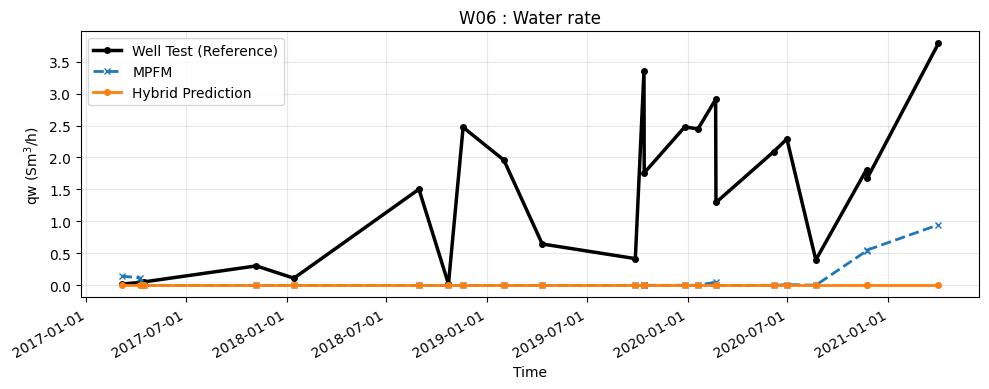

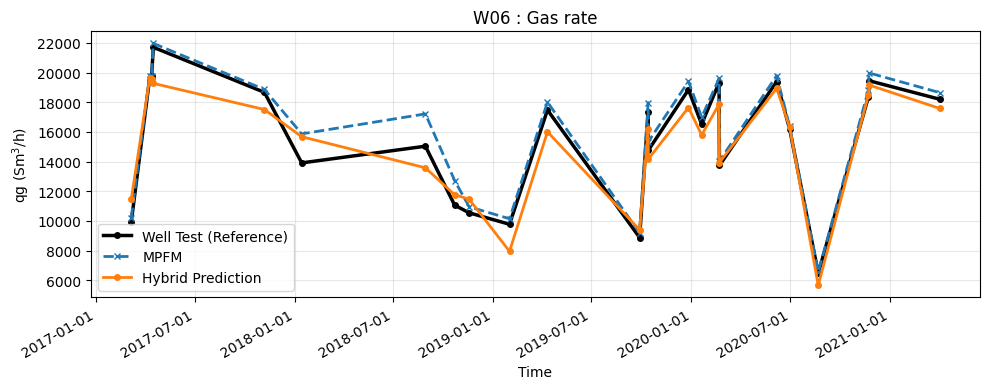

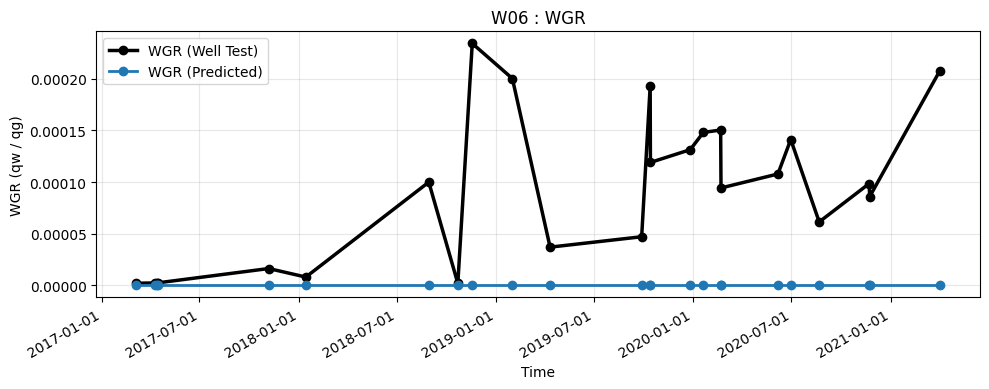

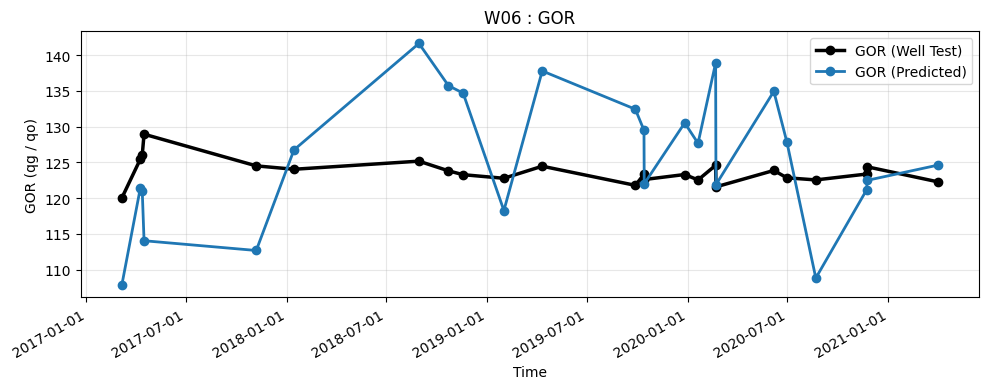

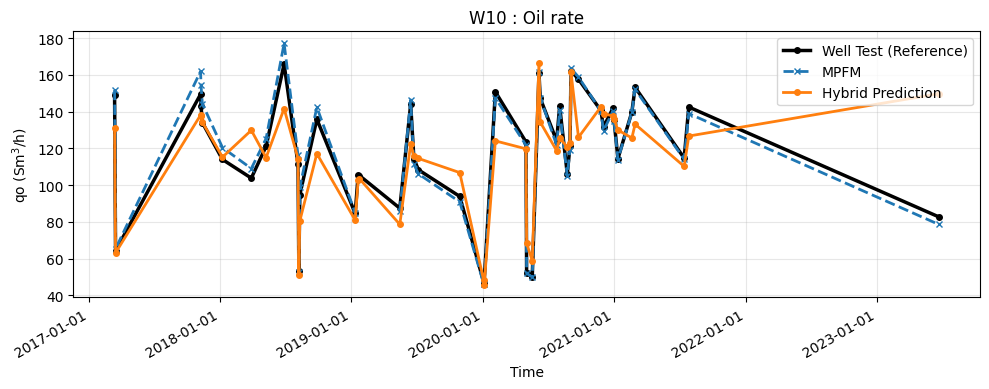

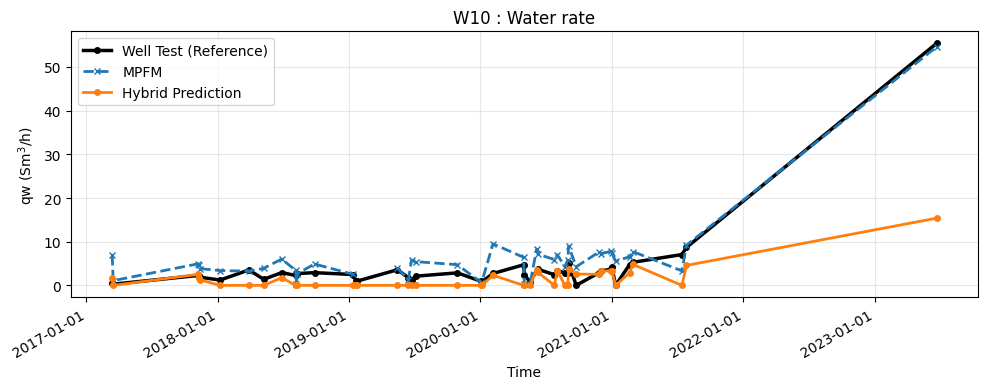

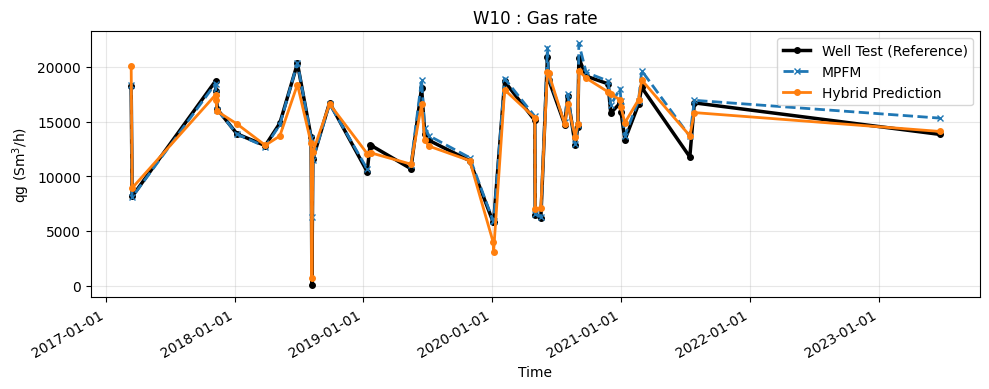

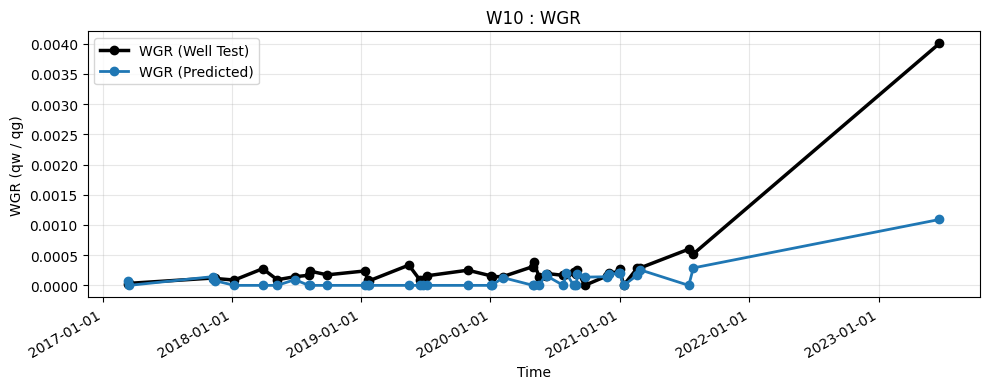

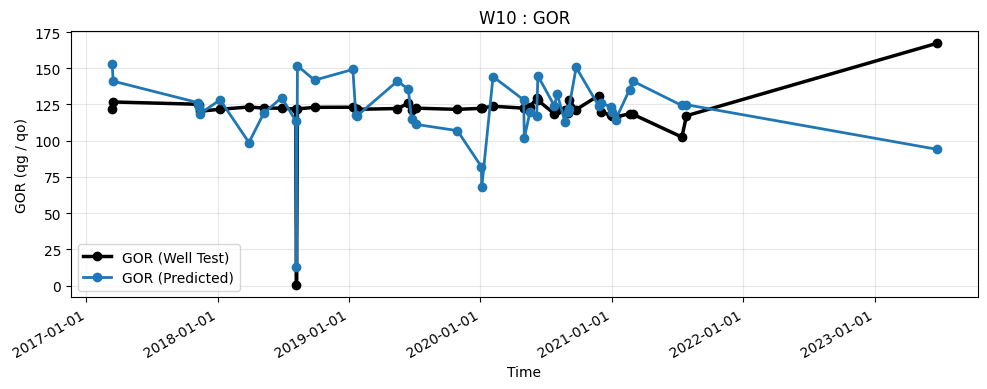

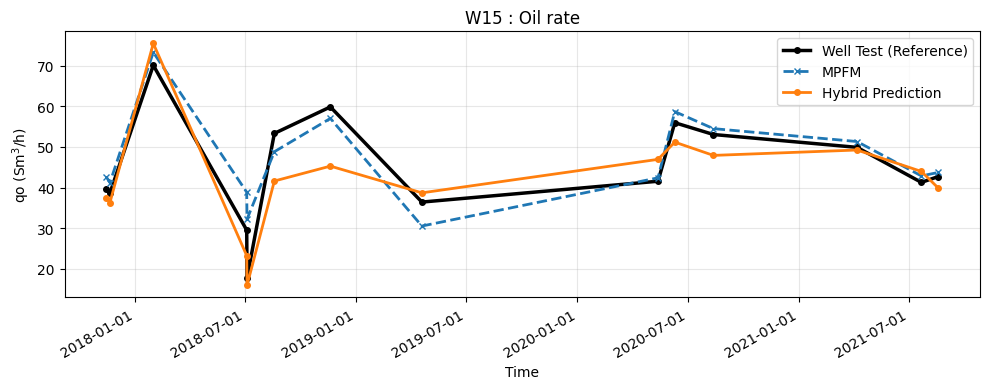

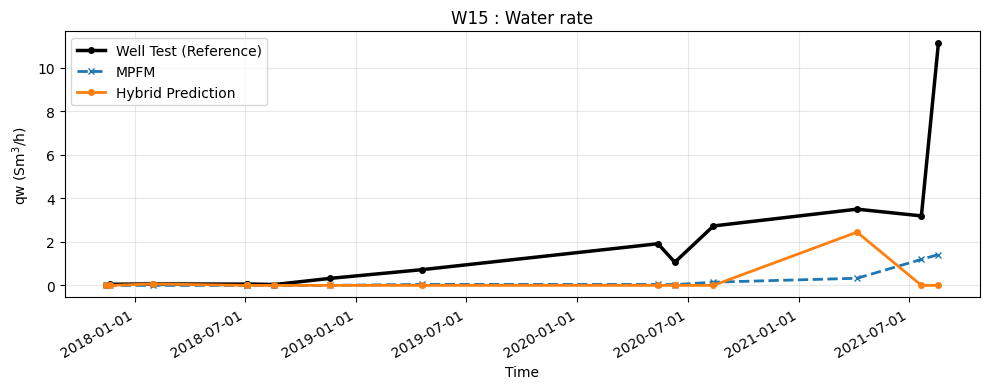

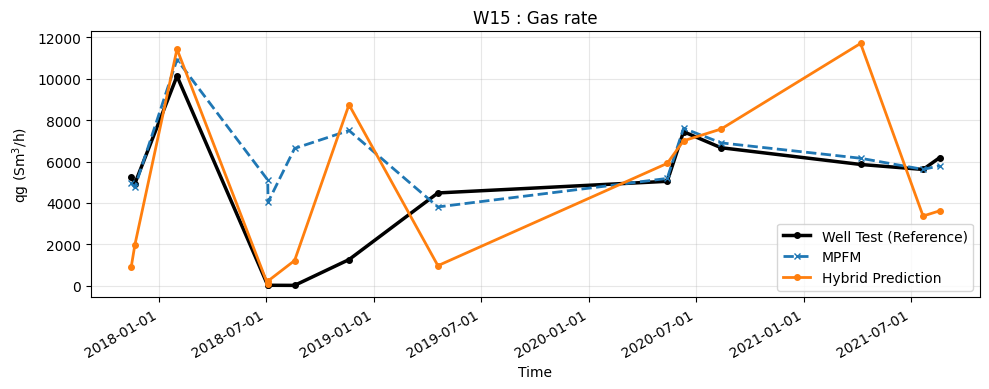

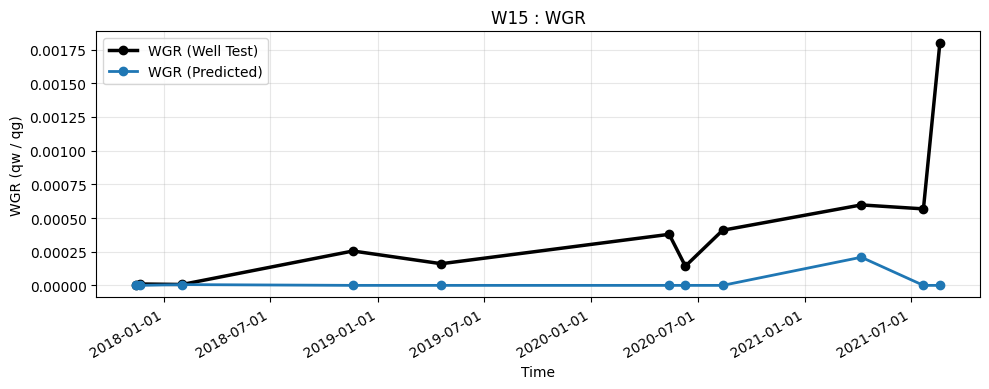

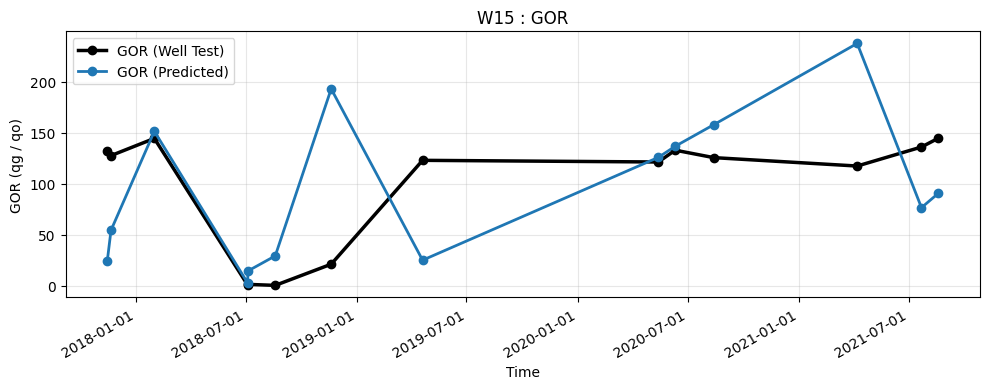

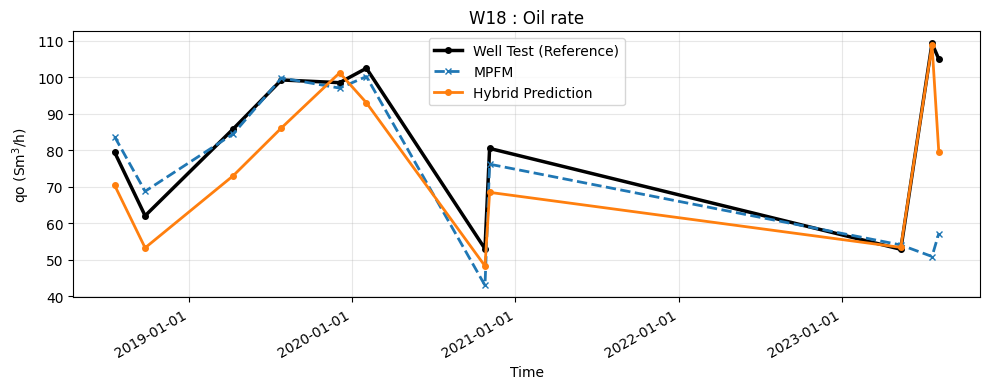

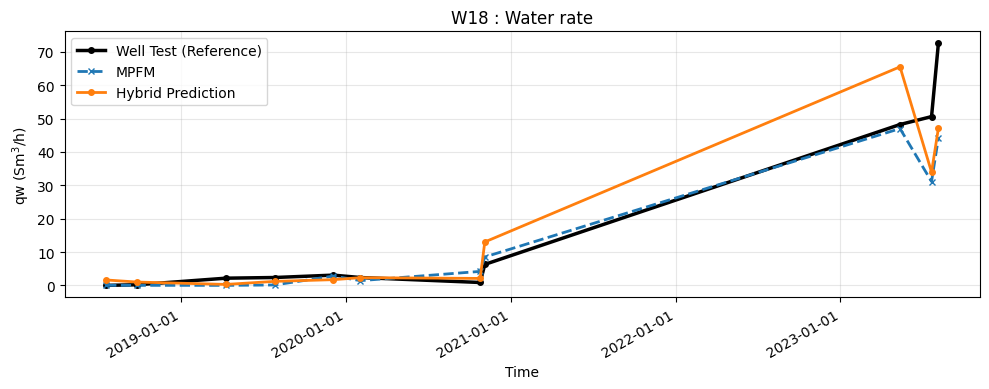

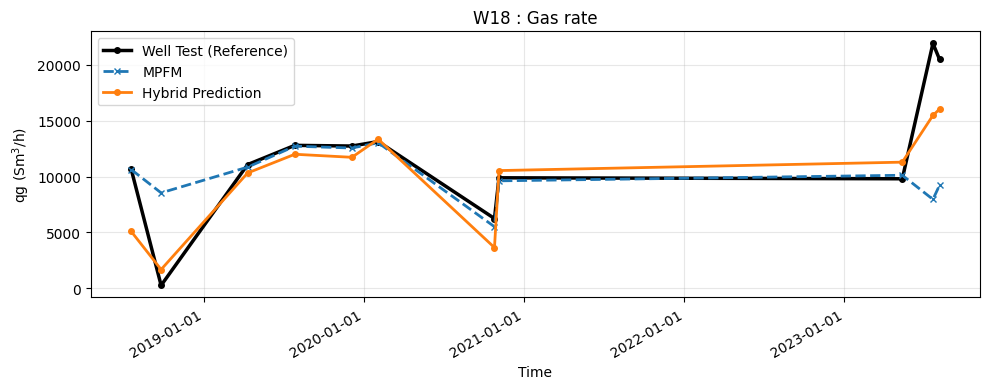

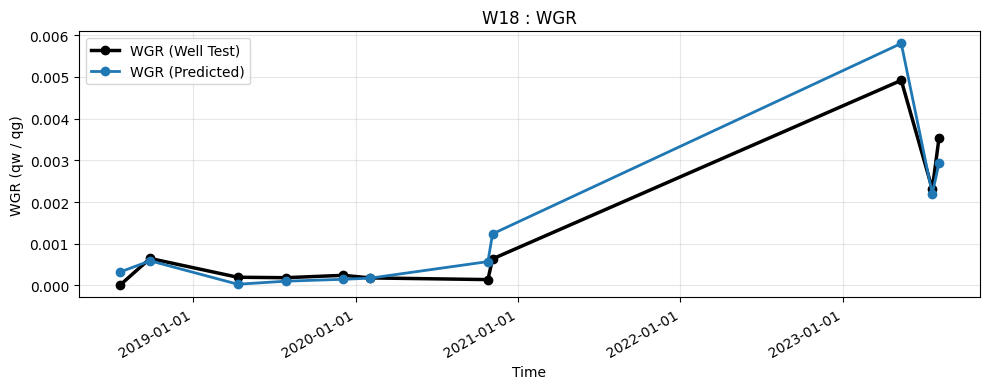

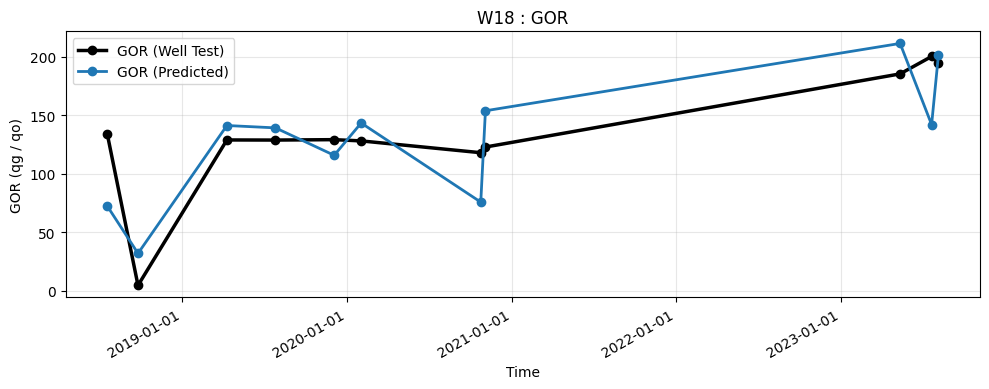

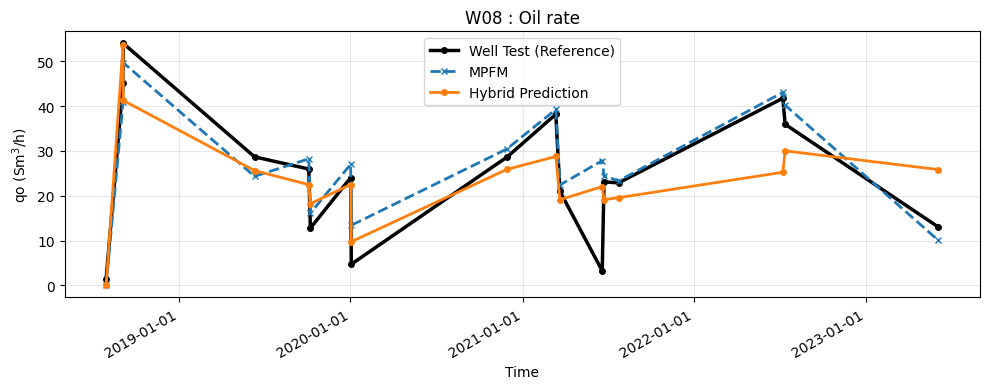

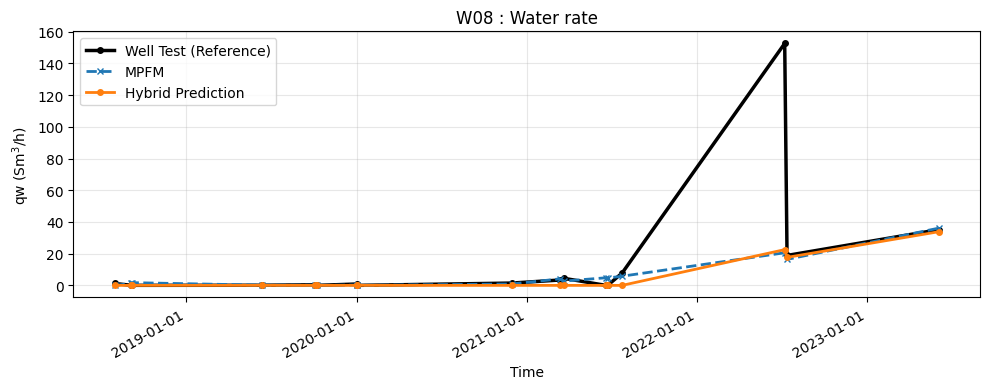

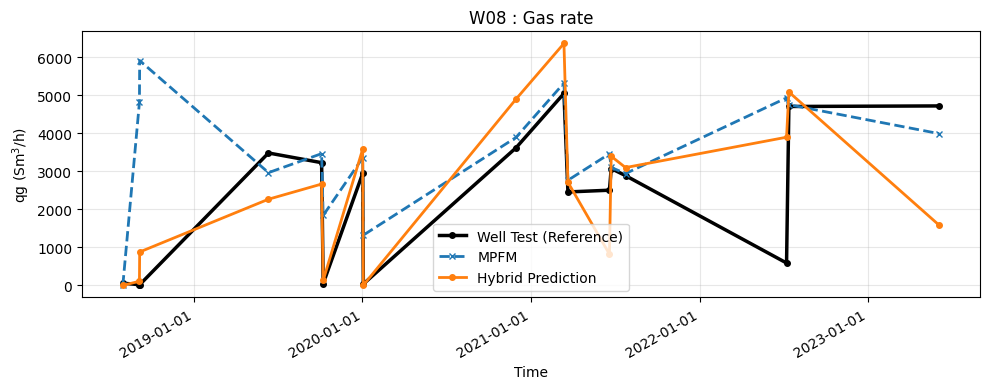

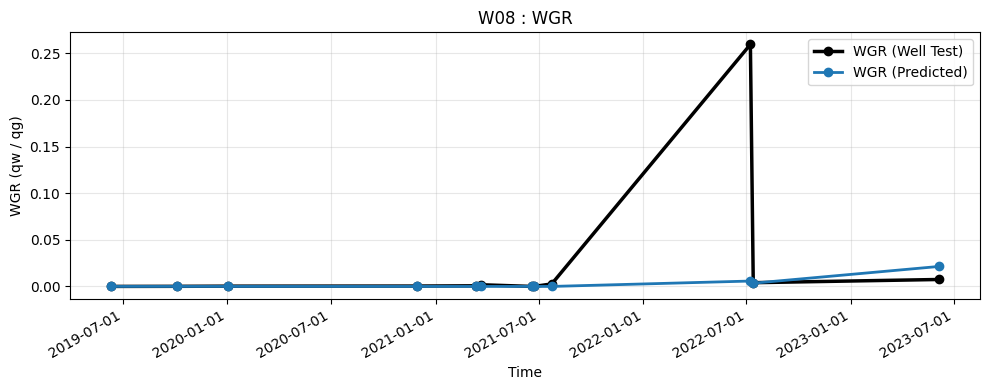

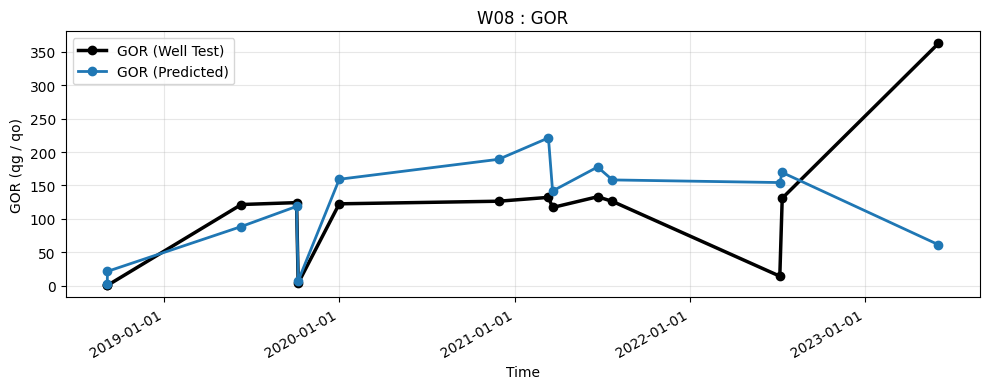

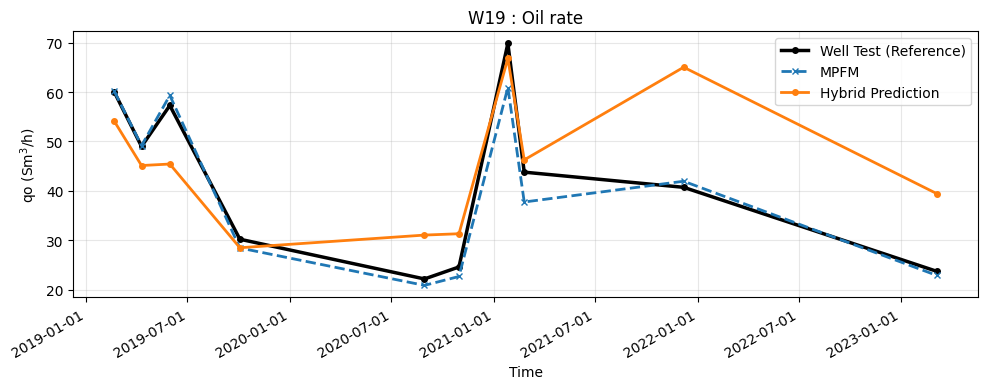

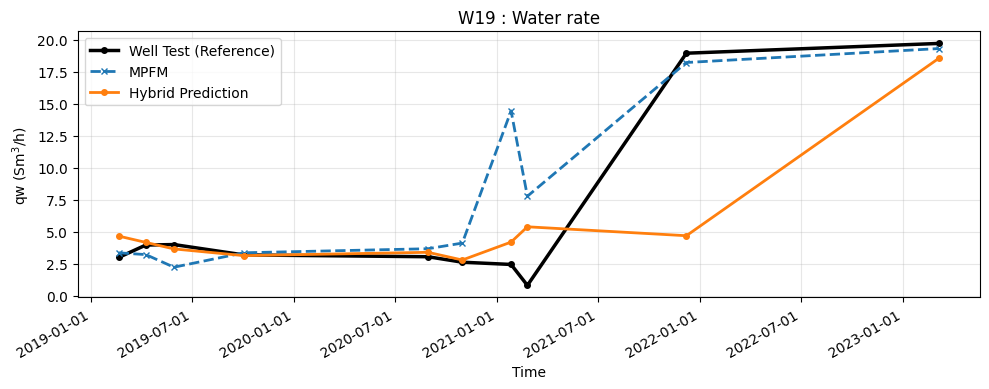

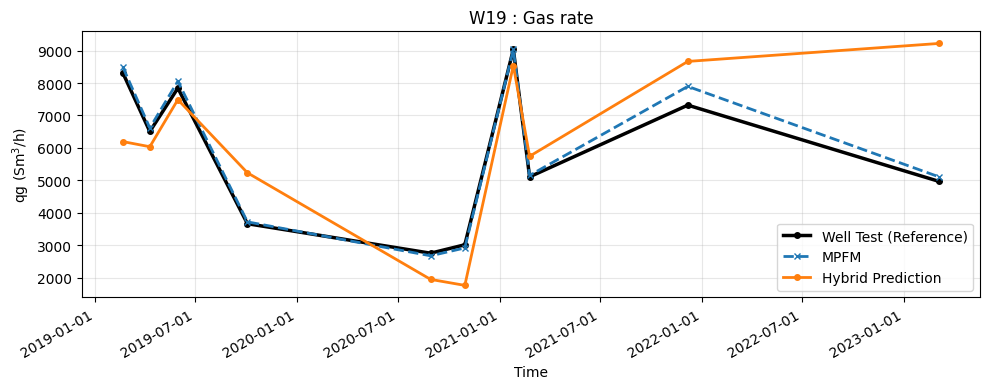

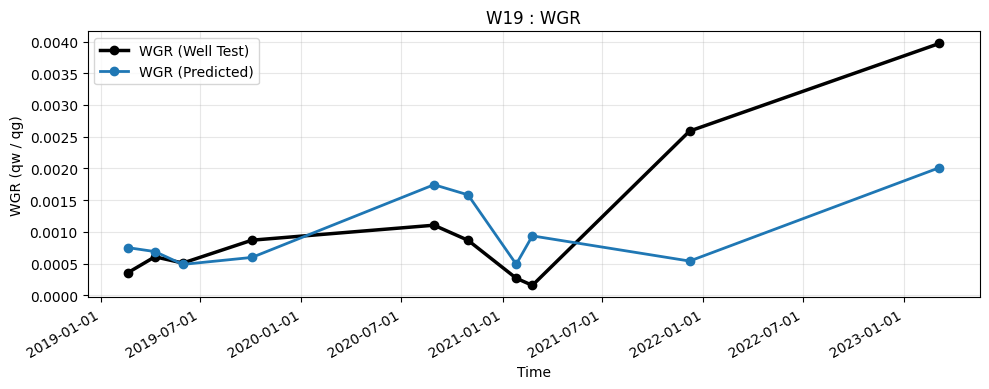

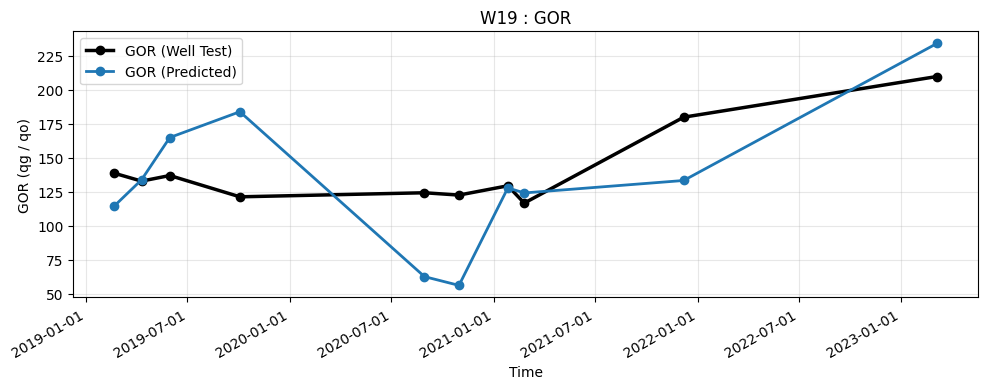

In [62]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [63]:
df_train_lowo, df_val_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10")
len(df_train_lowo), len(df_val_lowo), len(df_test_lowo)

(425, 109, 221)

In [64]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=None)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[Validation] Residual RMSE = 0.7982


In [65]:
model_lowo.calibrate_physics_only(df=df_test_lowo)

In [66]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.47556607433646114,
   'mae': 17.673619283289852,
   'rmse': 23.26900576668434,
   'mape (%)': 19.381442695370303,
   'mpe (%)': 8.482728497727122},
  'qw': {'r2': 0.6396998489882725,
   'mae': 3.2731687203182953,
   'rmse': 6.1805074094121295,
   'mape (%)': 22011.02805104232,
   'mpe (%)': 21932.476605536216},
  'qg': {'r2': 0.691385437494612,
   'mae': 1649.563876159395,
   'rmse': 2271.268719635514,
   'mape (%)': 232.71448572342436,
   'mpe (%)': 217.65237180905382},
  'wgr': {'r2': 0.45557523193624994,
   'mae': 0.00028794772374146513,
   'rmse': 0.0006643996875771597,
   'mape (%)': 125.96550838670599,
   'mpe (%)': 46.96848134019096},
  'gor': {'r2': -1.1536899379404049,
   'mae': 12.462169023049004,
   'rmse': 22.307053433829395,
   'mape (%)': 137.0551698544054,
   'mpe (%)': 120.09949095776436}}}

In [67]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.6537803362117356,
   'mae': 15.478715186782239,
   'rmse': 18.906376543847067,
   'mape (%)': 14.267854912269451,
   'mpe (%)': 4.62327744083075},
  'qw': {'r2': 0.7166064668894085,
   'mae': 3.1016128350306515,
   'rmse': 5.481341711001756,
   'mape (%)': 140.16960810229259,
   'mpe (%)': -7.730277778858668},
  'qg': {'r2': 0.13296903157815876,
   'mae': 3120.4168026188718,
   'rmse': 3806.9538937589223,
   'mape (%)': 75.66796719172855,
   'mpe (%)': 31.53502541756564},
  'wgr': {'r2': 0.5548893638627719,
   'mae': 0.0002605626668895003,
   'rmse': 0.0006007509527178107,
   'mape (%)': 89.09331906146922,
   'mpe (%)': -60.051304304088916},
  'gor': {'r2': -6.7706253252774244,
   'mae': 31.993779633120337,
   'rmse': 42.37196478290649,
   'mape (%)': 80.65188895017909,
   'mpe (%)': 34.066449095764526}}}

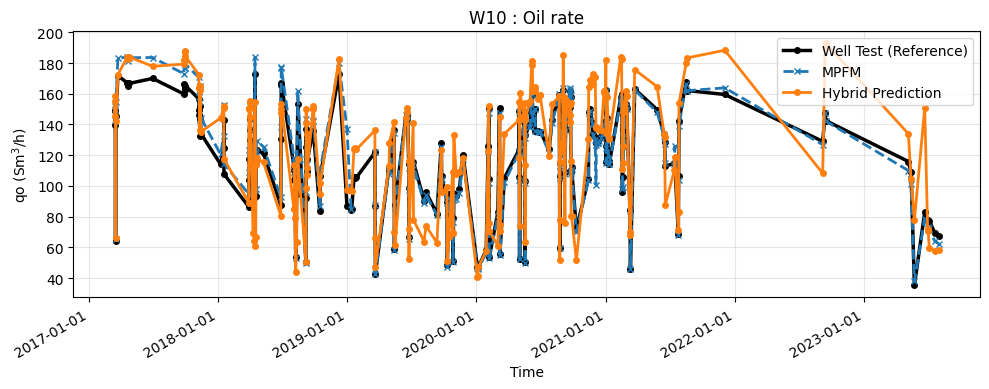

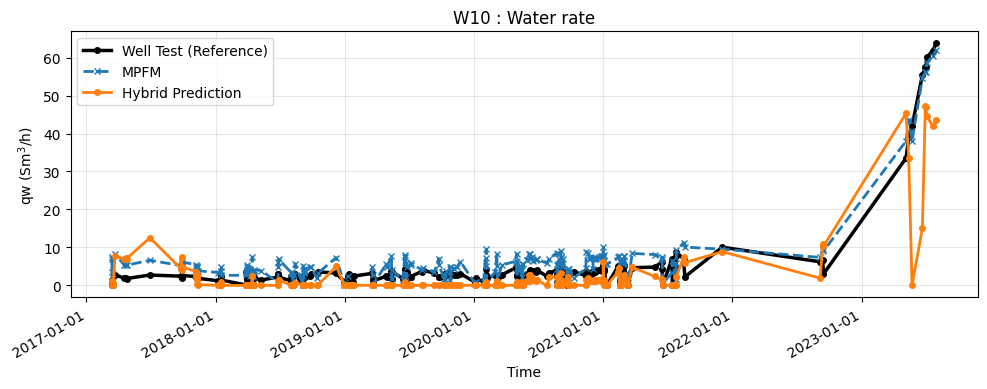

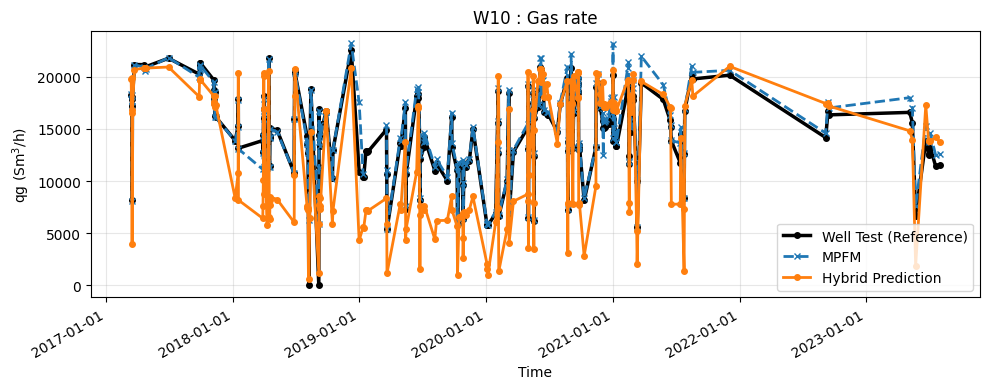

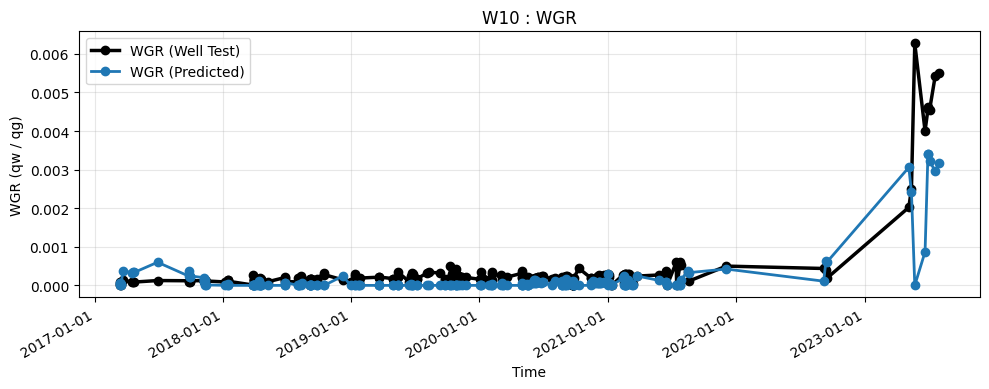

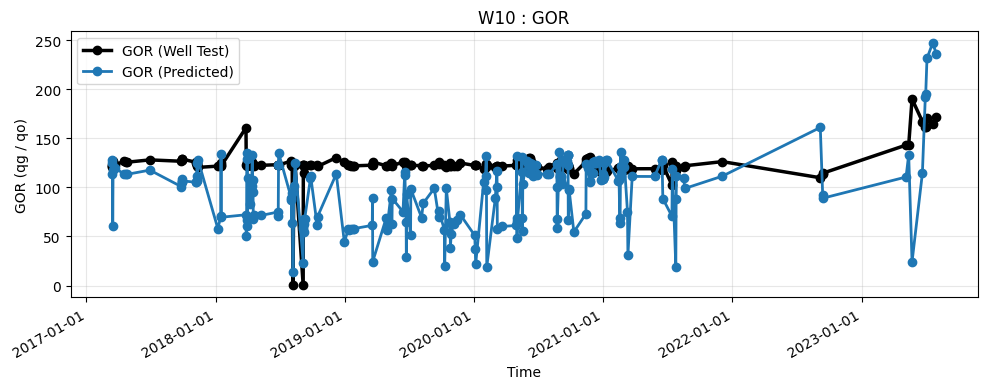

In [68]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [69]:
resampler = Resampler()
df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
print(summarize_null(df=df_resampled))
print(df_resampled.shape)

choke                 0
whp                   0
dcp                   0
dhp                   0
wht                   0
dht                   0
well_code             0
qo_well_test    2054830
qg_well_test    2054830
qw_well_test    2054830
qo_mpfm         2054860
qg_mpfm         2054860
qw_mpfm         2054860
wc_mpfm         2054830
time_idx              0
is_observed           0
well_id               0
dtype: int64
(2055585, 17)


In [70]:
df_resampled.index

RangeIndex(start=0, stop=2055585, step=1)

In [71]:
df_resampled.columns

Index(['choke', 'whp', 'dcp', 'dhp', 'wht', 'dht', 'well_code', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'qw_mpfm',
       'wc_mpfm', 'time_idx', 'is_observed', 'well_id'],
      dtype='object')

In [72]:
df_resampled[df_resampled["is_observed"] == 1].shape

(755, 17)

In [73]:
# Monotonic
df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

well_id
W06    True
W08    True
W10    True
W11    True
W15    True
W18    True
W19    True
Name: time_idx, dtype: bool

In [74]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [75]:
# summarize_null(df_generated)